In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [4]:
from image_utils import denormalize, show_single_image

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Set environment

In [7]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load `ImageNet` dataset

In [8]:
from imagenet.dataloader import get_imagenet_dls

In [9]:
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)

In [10]:
len(train_loader), len(val_loader)

(543, 62)

In [11]:
ds_val = val_loader.dataset

In [12]:
# check out a sample
index = 0
sample = ds_val[index]

In [13]:
sample["ims"].shape, sample["ims"].min(), sample["ims"].max(), sample["labels"]

(torch.Size([3, 224, 224]), tensor(-2.0837), tensor(2.6400), tensor(0))

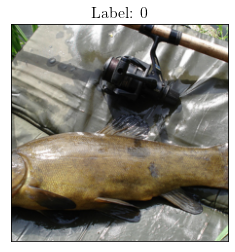

In [14]:
show_single_image(sample["ims"], title=f"Label: {sample['labels'].data}")

### Load model

In [15]:
from imagenet.models.classifier_ensemble import InvariantEnsemble

In [16]:
model = InvariantEnsemble("resnet50", pretrained=True)

In [17]:
# load weights from a checkpoint
ckpt_path = "imagenet/experiments/classifier_2022_01_19_15_36_sample_run/model_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt_state_dict = ckpt["state_dict"]
ckpt_state_dict = {k.replace("module.", ""):v for k, v in ckpt_state_dict.items()}

In [18]:
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [19]:
model = model.eval()

In [53]:
class IMModel(torch.nn.Module):

    def __init__(self, model, mode):
        super(IMModel, self).__init__()

        self.base_model = model
        self.mode = mode
        self.mechanism = f"m_{mode}"
    
    def forward(self, x):
        x = self.base_model.backbone(x)
        x = getattr(self.base_model, self.mechanism)(x)
        return x

In [54]:
class AverageEnsembleModel(torch.nn.Module):

    def __init__(self):
        super(AverageEnsembleModel, self).__init__()

        self.base_model = model
    
    def forward(self, x):
        x = self.base_model.backbone(x)
        x_shape = self.base_model.m_shape(x)
        x_texture = self.base_model.m_texture(x)
        x_bg = self.base_model.m_bg(x)
        x = (x_shape + x_texture + x_bg) / 3.0
        return x

In [55]:
head = "shape"

if head == "average":
    clf_model = AverageEnsembleModel()
elif head in ["shape", "texture", "bg"]:
    clf_model = IMModel(model=model, mode=head)
else:
    raise ValueError

### Apply GradCAM on a sample image

In [56]:
# define the target layer to be used
# target_layer = model.m_shape[1]
# target_layer = shape_model.base_model.m_shape[1]

target_layer = clf_model.base_model.backbone[7][2].conv1
gradcam = GradCAM(clf_model, target_layer)

alpha = 0.7

In [57]:
# get image
sample = ds_val[index]
image, label = sample["ims"], sample["labels"]

# get gradcam mask
gc_mask, _ = gradcam(image.unsqueeze(0))
heatmap, result = visualize_cam(gc_mask, image)
gc_mask = gc_mask.squeeze(0)

# compute custom result: alpha-linear combination of image (denormalized) and heatmap
denormalized_image = denormalize(image.data.cpu())
overlap = alpha * denormalized_image + (1 - alpha) * heatmap.data.cpu()

# create a grid with original, heatmap and overlapped
grid = make_grid([denormalized_image, heatmap, overlap], nrow=3)

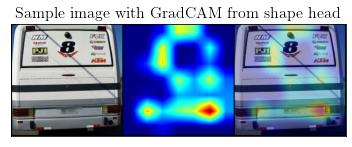

In [58]:
show_single_image(grid, normalized=False, title=f"Sample image with GradCAM from {head} head")

In [59]:
# Ideas
# 1. What happens without CF data?
# 2. What do each of the different heads focus on? Also, see what each head predicts? Relate that to the heatmap.

### Visualize heatmap for each head together

In [60]:
class SimpleGradCAM:
    """Extension of GradCAM class for our use-case."""

    def __init__(self, ensemble_model, alpha=0.7, target_layer=None):
        super(SimpleGradCAM, self).__init__()

        self.alpha = alpha
        
        self.m_shape = IMModel(model=ensemble_model, mode="shape")
        self.gradcam_shape = GradCAM(self.m_shape, self.m_shape.base_model.backbone[7][2].conv1)
        
        self.m_texture = IMModel(model=ensemble_model, mode="texture")
        self.gradcam_texture = GradCAM(self.m_texture, self.m_texture.base_model.backbone[7][2].conv1)

        self.m_bg = IMModel(model=ensemble_model, mode="bg")
        self.gradcam_bg = GradCAM(self.m_bg, self.m_bg.base_model.backbone[7][2].conv1)
    
    def apply_single_gradcam_module(self, image, gradcam_module, prefix):

        image = image.clone()

        # get gradcam mask
        gc_mask, _ = gradcam_module(image.unsqueeze(0))
        heatmap, result = visualize_cam(gc_mask, image)
        gc_mask = gc_mask.squeeze(0)

        # compute custom result: alpha-linear combination of image (denormalized) and heatmap
        denormalized_image = denormalize(image.data.cpu())
        overlap = self.alpha * denormalized_image + (1 - self.alpha) * heatmap.data.cpu()

        # create a grid with original, heatmap and overlapped
        grid_original_heatmap_overlap = make_grid([denormalized_image, heatmap, overlap], nrow=3)
        
        output = {
            "image": denormalized_image,
            f"{prefix}_heatmap": heatmap,
            f"{prefix}_overlap": overlap,
            f"{prefix}_grid_original_heatmap_overlap": grid_original_heatmap_overlap,
        }
        return output

    def apply(self, image: torch.tensor, label: torch.tensor):
        assert len(image.shape) == 3, "Works on a single-image only."
        assert image.shape[0] == 3

        outputs = dict()
        
        mechanisms = ["shape", "texture", "bg"]
        for i, prefix in enumerate(mechanisms):
            gradcam_module = getattr(self, f"gradcam_{prefix}")
            output = self.apply_single_gradcam_module(image, gradcam_module, prefix)
            outputs.update(output)

        outputs["gt_label"] = label.item()
        for i, prefix in enumerate(mechanisms):
            outputs[f"{prefix}_label"] = getattr(self, f"m_{prefix}")(image.unsqueeze(0)).argmax(1)[0].cpu().item()

        return outputs

In [61]:
simple_gradcam = SimpleGradCAM(ensemble_model=model)

In [62]:
# get image
index = 3000
sample = ds_val[index]
image, label = sample["ims"], sample["labels"]

outputs = simple_gradcam.apply(image, label)

In [63]:
outputs["gt_label"], outputs["shape_label"], outputs["texture_label"], outputs["bg_label"]

(757, 266, 675, 751)

In [64]:
grid = make_grid([outputs["image"], outputs["shape_overlap"], outputs["texture_overlap"], outputs["bg_overlap"]], nrow=4)

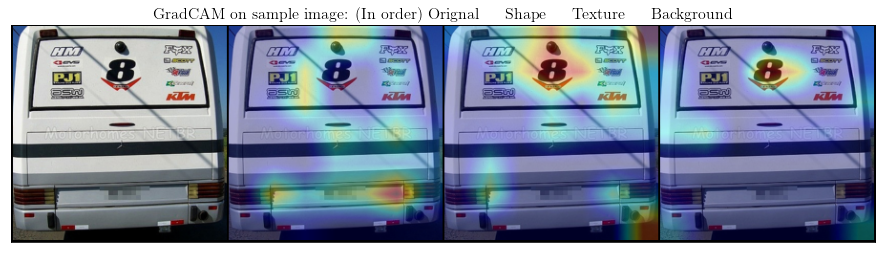

In [65]:
show_single_image(
    grid,
    title="GradCAM on sample image: (In order) Orignal   \ \ \ \  Shape    \ \ \ \   Texture    \ \ \ \  Background",
    figsize=(16, 4),
    normalized=False,
)